In [11]:
import shutil
import os

In [12]:
def create_dir_if_not_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [13]:
for i in range(1, 20):
    create_dir_if_not_exists(f"../data/H{i}")

### Run .\move_images.ps1 to move images

In [14]:
# split data into train, val, test
import os
import shutil
from sklearn.model_selection import train_test_split
import random

def create_dataset_split(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """
    Split images from each class into train/val/test sets
    """
    # create destination directories
    for split in ['train', 'val', 'test']:
        for class_name in os.listdir(source_dir):
            if class_name.startswith('H'):
                split_dir = os.path.join(dest_dir, split, class_name)
                os.makedirs(split_dir, exist_ok=True)
    
    # split each class
    for class_name in os.listdir(source_dir):
        if not class_name.startswith('H'):
            continue
            
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue
            
        # get all images in this class
        images = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
        print(f"Processing {class_name}: {len(images)} images")
        
        if len(images) < 3:
            print(f"Warning: {class_name} has only {len(images)} images, skipping stratified split")
            continue
            
        # split the images
        train_val, test = train_test_split(images, test_size=test_ratio, random_state=42)
        train, val = train_test_split(train_val, test_size=val_ratio/(train_ratio+val_ratio), random_state=42)
        
        # copy files to respective directories
        for img in train:
            shutil.copy2(os.path.join(class_path, img), 
                        os.path.join(dest_dir, 'train', class_name, img))
        
        for img in val:
            shutil.copy2(os.path.join(class_path, img), 
                        os.path.join(dest_dir, 'val', class_name, img))
            
        for img in test:
            shutil.copy2(os.path.join(class_path, img), 
                        os.path.join(dest_dir, 'test', class_name, img))
        
        print(f"  {class_name}: {len(train)} train, {len(val)} val, {len(test)} test")

# Usage
source_directory = "../data"  # current data folder
destination_directory = "../dataset"  # new dataset folder

create_dataset_split(source_directory, destination_directory)

Processing H1: 0 images
Processing H10: 0 images
Processing H11: 0 images
Processing H12: 0 images
Processing H13: 0 images
Processing H14: 0 images
Processing H15: 0 images
Processing H16: 0 images
Processing H17: 0 images
Processing H18: 0 images
Processing H19: 0 images
Processing H2: 0 images
Processing H3: 0 images
Processing H4: 0 images
Processing H5: 0 images
Processing H6: 0 images
Processing H7: 0 images
Processing H8: 0 images
Processing H9: 0 images


### Create Label CSV

In [15]:
import csv

def create_labels_csv(dataset_dir, output_csv_path, total_days=12):
    """
    Create a CSV file with image paths and their corresponding days left labels
    """
    with open(output_csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Write header
        writer.writerow(['image_path', 'days_left', 'split'])
        
        # Process each split (train, val, test)
        for split in ['train', 'val', 'test']:
            split_dir = os.path.join(dataset_dir, split)
            
            if not os.path.exists(split_dir):
                continue
                
            print(f"Processing {split} split...")
            
            # Process each class folder
            for class_folder in os.listdir(split_dir):
                if not class_folder.startswith('H'):
                    continue
                    
                class_path = os.path.join(split_dir, class_folder)
                if not os.path.isdir(class_path):
                    continue
                
                # Extract the day number from folder name (H1 -> 1, H2 -> 2, etc.)
                day_number = int(class_folder.replace('H', ''))
                
                # Calculate days left (assuming total shelf life is 12 days)
                days_left = total_days - day_number
                
                print(f"  {class_folder}: {days_left} days left")
                
                # Process all images in this class
                for image_file in os.listdir(class_path):
                    if not image_file.endswith('.jpg'):
                        continue
                    
                    # Create relative path from dataset directory
                    image_path = os.path.join(split, class_folder, image_file)
                    
                    # Write row to CSV
                    writer.writerow([image_path, days_left, split])

# Create the labels CSV
create_labels_csv("../dataset", "../dataset/labels.csv", total_days=12)
print("Labels CSV created successfully!")

Processing train split...
  H1: 11 days left
  H10: 2 days left
  H11: 1 days left
  H12: 0 days left
  H13: -1 days left
  H14: -2 days left
  H15: -3 days left
  H16: -4 days left
  H17: -5 days left
  H18: -6 days left
  H19: -7 days left
  H2: 10 days left
  H3: 9 days left
  H4: 8 days left
  H5: 7 days left
  H6: 6 days left
  H7: 5 days left
  H8: 4 days left
  H9: 3 days left
Processing val split...
  H1: 11 days left
  H10: 2 days left
  H11: 1 days left
  H12: 0 days left
  H13: -1 days left
  H14: -2 days left
  H15: -3 days left
  H16: -4 days left
  H17: -5 days left
  H18: -6 days left
  H19: -7 days left
  H2: 10 days left
  H3: 9 days left
  H4: 8 days left
  H5: 7 days left
  H6: 6 days left
  H7: 5 days left
  H8: 4 days left
  H9: 3 days left
Processing test split...
  H1: 11 days left
  H10: 2 days left
  H11: 1 days left
  H12: 0 days left
  H13: -1 days left
  H14: -2 days left
  H15: -3 days left
  H16: -4 days left
  H17: -5 days left
  H18: -6 days left
  H19: 

### Create Custom PyTorch Dataset Class

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision.io import decode_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, split="train", transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)

        # filter by split
        self.img_labels = self.img_labels[self.img_labels["split"] == split]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Prepare data for training with DataLoaders

In [17]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torch

transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize the images to 224x224
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet normalization
])

train_dataset = CustomImageDataset("../dataset/labels.csv", "../dataset", split="train", transform=transform)
val_dataset = CustomImageDataset("../dataset/labels.csv", "../dataset", split="val", transform=transform)
test_dataset = CustomImageDataset("../dataset/labels.csv", "../dataset", split="test", transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

### Iterate through dataloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6041614..2.1171243].


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


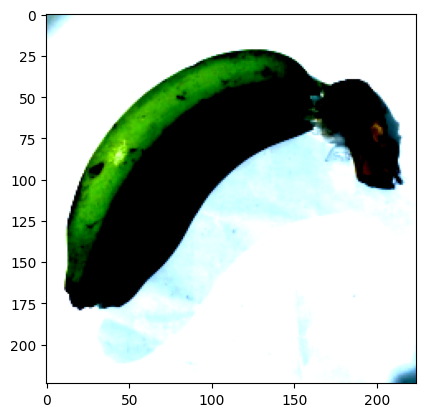

Label: 9


In [18]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

### Try getting GPU
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [19]:
import torch 

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Implement ViT Regressions Model

In [20]:
import timm
import torch.nn as nn

class BananaViTRegressor(nn.Module):
    def __init__(self):
        super(BananaViTRegressor, self).__init__()

        # load pretrained ViT model
        self.vit = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=0)

        # add the regression head
        self.regressor = nn.Sequential(
            nn.LayerNorm(768), # ViT based has 768 dim embeddings
            nn.Linear(768, 512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1) # single output for our regression task
        )
        
    def forward(self, x):
        # get the ViT features(logits)
        features = self.vit(x)

        # pass features to the regressor
        return self.regressor(features)
    
# create the model
model = BananaViTRegressor().to(device)

print(f"ViT regression model created on {device}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

c:\Users\gael8\anaconda3\envs\ba\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\gael8\anaconda3\envs\ba\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\gael8\.cache\huggingface\hub\models--timm--vit_base_patch16_224.augreg2_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In or

ViT regression model created on cuda
Trainable parameters: 86358273


### Loss Function and Optimizer

In [21]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# loss function
criterion = nn.MSELoss()

# optimizer (AdamW better for regression than regular Adam)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=20)

print("Loss function, optimizer, scheduler configured")

Loss function, optimizer, scheduler configured


### Define Training Function

In [ ]:
def train_vit_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    """
    train a ViT model for regression task
    """
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # training phase
        model.train()
        running_train_loss = 0.0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device).float()

            # zero gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            # backward pass
            loss.backward()
            optimizer.step()

            # update running loss
            running_train_loss += loss.item()

            # print progress every 10 batches
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Train Loss: {loss.item():.4f}")

        # calculate average training loss
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # validation phase
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device).float()
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # update learning rate
        scheduler.step()

        # print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # save best model
            torch.save(model.state_dict(), f"../best_vit_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    return train_losses, val_losses

print("Training function defined")

Training function defined


### Train the Model

In [23]:
num_epochs = 20

print("Starting training...")
train_losses, val_losses = train_vit_model(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
)

print("Training complete!")

Starting training...
Epoch 1/20, Batch 1/25, Train Loss: 48.3521
Epoch 1/20, Batch 11/25, Train Loss: 30.2094
Epoch 1/20, Batch 21/25, Train Loss: 14.1398
Epoch 1/20, Train Loss: 27.4248, Val Loss: 9.5724
Epoch 2/20, Batch 1/25, Train Loss: 10.8287
Epoch 2/20, Batch 11/25, Train Loss: 8.0464
Epoch 2/20, Batch 21/25, Train Loss: 5.6594
Epoch 2/20, Train Loss: 6.9223, Val Loss: 3.1619
Epoch 3/20, Batch 1/25, Train Loss: 4.2228
Epoch 3/20, Batch 11/25, Train Loss: 2.0303
Epoch 3/20, Batch 21/25, Train Loss: 1.5976
Epoch 3/20, Train Loss: 2.2354, Val Loss: 1.7544
Epoch 4/20, Batch 1/25, Train Loss: 2.7579
Epoch 4/20, Batch 11/25, Train Loss: 2.4179
Epoch 4/20, Batch 21/25, Train Loss: 1.6135
Epoch 4/20, Train Loss: 1.5770, Val Loss: 1.1705
Epoch 5/20, Batch 1/25, Train Loss: 1.3902
Epoch 5/20, Batch 11/25, Train Loss: 1.7101
Epoch 5/20, Batch 21/25, Train Loss: 0.8766
Epoch 5/20, Train Loss: 1.1904, Val Loss: 0.8653
Epoch 6/20, Batch 1/25, Train Loss: 0.9839
Epoch 6/20, Batch 11/25, Train 

In [ ]:
# Vibe Coded 
def evaluate_vit_model(model, test_loader, criterion):
    """
    Evaluate the trained model on test set
    """
    model.eval()
    test_loss = 0.0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device).float()
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()
            
            # Store predictions and actuals
            predictions.extend(outputs.squeeze().cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    
    # Calculate final metrics
    avg_test_loss = test_loss / len(test_loader)
    
    # Calculate MAE and RMSE
    from sklearn.metrics import mean_absolute_error
    import numpy as np
    
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(avg_test_loss)
    
    print("Test Results:")
    print(f"MSE Loss: {avg_test_loss:.4f}")
    print(f"MAE: {mae:.4f} days")
    print(f"RMSE: {rmse:.4f} days")
    
    return predictions, actuals, mae, rmse

# Load best model and evaluate
model.load_state_dict(torch.load('../best_vit_model.pth'))
predictions, actuals, mae, rmse = evaluate_vit_model(model, test_dataloader, criterion)

Test Results:
MSE Loss: 0.6260
MAE: 0.5792 days
RMSE: 0.7912 days


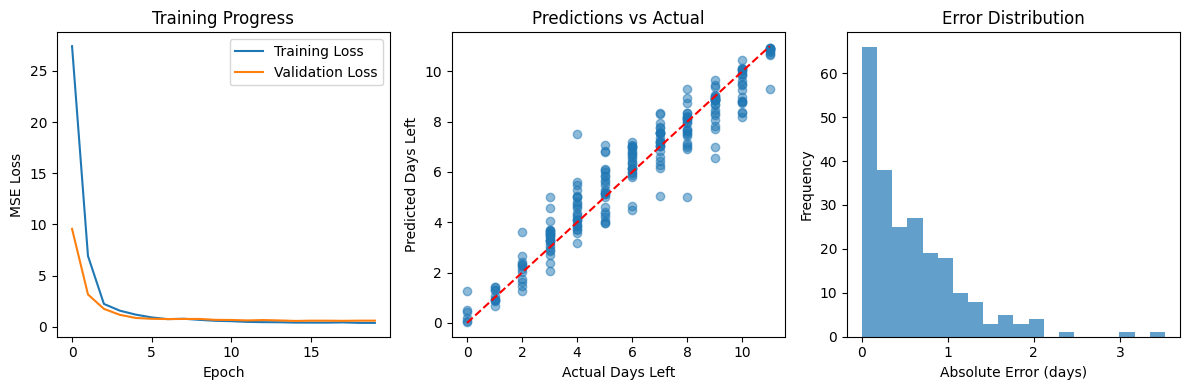

Model Performance Summary:
Mean Absolute Error: 0.58 days
Root Mean Square Error: 0.79 days


In [25]:
# Vibe Coded
import matplotlib.pyplot as plt

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training Progress')

plt.subplot(1, 3, 2)
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
plt.xlabel('Actual Days Left')
plt.ylabel('Predicted Days Left')
plt.title('Predictions vs Actual')

plt.subplot(1, 3, 3)
errors = [abs(p - a) for p, a in zip(predictions, actuals)]
plt.hist(errors, bins=20, alpha=0.7)
plt.xlabel('Absolute Error (days)')
plt.ylabel('Frequency')
plt.title('Error Distribution')

plt.tight_layout()
plt.show()

print(f"Model Performance Summary:")
print(f"Mean Absolute Error: {mae:.2f} days")
print(f"Root Mean Square Error: {rmse:.2f} days")

### Save the Model

In [27]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': len(train_losses),
    'mae': mae,
    'rmse': rmse
}, '../banana_ripness_predictor.pth')

### Prediction Function

In [30]:
from PIL import Image
def predict_ripeness(image_path):
    """
    Predict days until a banana is rotten
    """
    model.eval()
    
    # load and preprocess image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)), # resize image to 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        prediction = model(image).item()
    
    return max(0, prediction)  # ensure non-negative

### Example Usage

In [ ]:
image_path = "../dataset/test/H1/Vivo_1_H1f1_Kanan.jpg"
days_left = predict_ripeness(image_path)
print(f"Predicted days left until rotten: {days_left:.2f} days")

Predicted days left: 10.89 days
